In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import gc
from captum.attr import *
import quantus
from torch.utils.data import DataLoader
import gc
import torchvision.transforms as transforms

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
#for natural and adversarial LeNet Model 
class LeNet_normal(torch.nn.Module):
    """Network architecture from: https://github.com/ChawDoe/LeNet5-MNIST-PyTorch."""
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.relu_1 = torch.nn.ReLU()
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.relu_2 = torch.nn.ReLU()
        self.fc_1 = torch.nn.Linear(256, 120)
        self.relu_3 = torch.nn.ReLU()
        self.fc_2 = torch.nn.Linear(120, 84)
        self.relu_4 = torch.nn.ReLU()
        self.fc_3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [5]:
def load_mnist_model(path):
    model = LeNet_normal()
    model.to(device)
    model.load_state_dict(torch.load(path))
    model.to('cuda')
    model.train(False)
    return model

In [6]:
modelpath = "/data/virtual environments/adv detection by robustness/adv_detection/Adaptive attacks/Models/MNIST/mnist_model.pth"

In [8]:
normal_model = load_mnist_model(modelpath)
normal_model.to(device)
normal_model.eval()

LeNet_normal(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_2): ReLU()
  (fc_1): Linear(in_features=256, out_features=120, bias=True)
  (relu_3): ReLU()
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (relu_4): ReLU()
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
import pandas as pd

In [10]:
def make_noise(x_batch, y_batch, spread):
    new_x_batch = []
    for x in x_batch:
        x = x.data.cpu().numpy()
        stdev = spread * (np.max(x)-np.min(x))
        noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
        x_plus_noise = x + noise
        x_plus_noise = np.clip(x_plus_noise, 0, 1)
        x_plus_noise = torch.from_numpy(x_plus_noise).cpu()
        new_x_batch.append(x_plus_noise)
    new_batch = torch.stack(new_x_batch).to(device)
    return new_batch

In [11]:
def compute_metrics_benign(adv_path, normal_model, noise_parameter): 
    
    print("Computing metrics for {} for benign")
    
    npobj = np.load(adv_path)
    adaptive_image = npobj['b_images']
    adaptive_label = npobj['b_labels']
    
    
    #attribution robustness
    attribution_gaussian1 = []
    #logit robustness
    logit_gaussian1 = []
   
    
    images, labels = torch.from_numpy(adaptive_image), torch.from_numpy(adaptive_label)
    #images, labels = images.to(device), labels.to(device)
    
    end = len(adaptive_label)
    if end > 1000:
        end = 1000
    
    for i in range(0, end, 2):
        
        images_adv, y_pred_adv = images[i:i+2], labels[i:i+2]
        images_adv, y_pred_adv = images_adv.to(device), y_pred_adv.to(device)
        
        x_logits = normal_model(images_adv)
        gc.collect()
        torch.cuda.empty_cache()
        
        #approach: attribution and logit robustness
        a_batch = quantus.explain(
            model=normal_model, inputs=images_adv, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        
        gaussian_noisy_images_1 = make_noise(images_adv, y_pred_adv, spread = noise_parameter)
        gaussian_logits_1 = normal_model(gaussian_noisy_images_1)
        
        
        diff1 = torch.norm(x_logits-gaussian_logits_1,p=1, dim=1) 
        logit_gaussian1.extend(diff1.detach().cpu().numpy())
        
        
        
        a_batch_gaussian1 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_1, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
            
        for a, b in zip(a_batch, a_batch_gaussian1):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian1.append(c)
            
       
        
    df = pd.DataFrame([
            attribution_gaussian1,
            logit_gaussian1], index = [
            "Gaussian1 attribution", 
            "Gaussian1 logit robusntess"
                    ])
            
    path = "adaptive_Benign.csv"
    df.to_csv(path)

In [14]:
def return_thresholds(data_path, model):
    noise_ = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01,0.03, 0.05, 0.07, 0.10]
    final_auc_list = []
    final_tpr_list = [] 
    final_fpr_list = [] 
    
    for noise_p in noise_:
        print('computing evaluations for noise {} '.format(noise_p))
        compute_metrics_benign(data_path, model, noise_p)
        df_cifar = pd.read_csv("adaptive_Benign.csv")
        attr_gaussian3 = df_cifar.iloc[0].values.flatten().tolist()[1:]
        logit_gaussian3 = df_cifar.iloc[1].values.flatten().tolist()[1:]
        print('Minimum attr:', min(attr_gaussian3))
        print('Maximum attr:', max(attr_gaussian3))
        print('Minimum logit:', min(logit_gaussian3))
        print('Maximum logit:', max(logit_gaussian3))
        print('---------')

In [15]:
data_path = 'adv samples/MNIST/FGSM/0.03137254901960784eps.npz'
return_thresholds(data_path, normal_model)

computing evaluations for noise 0.001 
Computing metrics for {} for benign
Minimum attr: 4.2724423e-07
Maximum attr: 233.75424
Minimum logit: 0.009063244
Maximum logit: 0.9191055
---------
computing evaluations for noise 0.002 
Computing metrics for {} for benign
Minimum attr: 9.154901e-07
Maximum attr: 212.17314
Minimum logit: 0.013617158
Maximum logit: 2.181942
---------
computing evaluations for noise 0.003 
Computing metrics for {} for benign
Minimum attr: 1.3299286e-06
Maximum attr: 283.53784
Minimum logit: 0.03462434
Maximum logit: 2.8588233
---------
computing evaluations for noise 0.004 
Computing metrics for {} for benign
Minimum attr: 9.536743e-07
Maximum attr: 386.27377
Minimum logit: 0.06614268
Maximum logit: 4.640523
---------
computing evaluations for noise 0.005 
Computing metrics for {} for benign
Minimum attr: 2.1662563e-06
Maximum attr: 295.55814
Minimum logit: 0.051588535
Maximum logit: 5.4401026
---------
computing evaluations for noise 0.006 
Computing metrics for 

In [16]:
import numpy as np

k=[]
l=[]
m=[]
n=[]

k1=10*[0.005]
l1= np.linspace(0.1,1.5, 10).tolist()

m1=10*[4.2724423e-05]
n1= np.linspace(5,200, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [17]:
k1=10*[0.005]
l1= np.linspace(0.1,1.7, 10).tolist()

m1=10*[4.2724423e-05]
n1= np.linspace(5,200, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [18]:
k1=10*[0.005]
l1= np.linspace(0.1,2, 10).tolist()

m1=10*[4.2724423e-05]
n1= np.linspace(5,200, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [19]:
k1=10*[0.005]
l1= np.linspace(0.1,3, 10).tolist()

m1=10*[4.2724423e-05]
n1= np.linspace(5,200, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [20]:
k1=10*[0.005]
l1= np.linspace(0.1,4, 10).tolist()

m1=10*[4.2724423e-05]
n1= np.linspace(5,200, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [21]:
k1=10*[0.005]
l1= np.linspace(0.1,6, 10).tolist()

m1=10*[4.2724423e-05]
n1= np.linspace(5,260, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [22]:
k1=10*[0.005]
l1= np.linspace(0.1,7, 10).tolist()

m1=10*[4.2724423e-05]
n1= np.linspace(5,260, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [23]:
k1=10*[0.005]
l1= np.linspace(0.1,7, 10).tolist()

m1=10*[4.2724423e-05]
n1= np.linspace(5,260, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [24]:
k1=10*[0.005]
l1= np.linspace(0.5,8, 10).tolist()

m1=10*[0.1]
n1= np.linspace(5,360, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [25]:
k1=10*[0.005]
l1= np.linspace(0.5,20, 10).tolist()

m1=10*[0.1]
n1= np.linspace(5,500, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [26]:
k1=10*[0.005]
l1= np.linspace(1.0,40, 10).tolist()

m1=10*[0.1]
n1= np.linspace(5,800, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [27]:
k1=10*[0.005]
l1= np.linspace(1.0,50, 10).tolist()

m1=10*[0.1]
n1= np.linspace(5,800, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [28]:
k1=10*[0.005]
l1= np.linspace(1.0,50, 10).tolist()

m1=10*[0.1]
n1= np.linspace(5,800, 10).tolist()

k.append(k1)
l.append(l1)
m.append(m1)
n.append(n1)

In [29]:
len(k1), len(l1), len(m1), len(n1)

(10, 10, 10, 10)

In [30]:
len(k)

13

In [31]:
def compute_metrics_adv(adv_path, normal_model, noise_parameter): 
    
    print("Computing metrics for {} for adv")
    npobj = np.load(adv_path)
    adaptive_image = npobj['a_images']
    adaptive_label = npobj['a_labels']
    
    #attribution robustness
    attribution_gaussian1 = []
    
    #logit robustness
    logit_gaussian1 = []
  
    images, labels = torch.from_numpy(adaptive_image), torch.from_numpy(adaptive_label)
    #images, labels = images.to(device), labels.to(device)
    
    end = len(adaptive_label)
    if end > 1000:
        end = 1000
    
    for i in range(0, end, 2):
        
        images_adv, y_pred_adv = images[i:i+2], labels[i:i+2]
        images_adv, y_pred_adv = images_adv.to(device), y_pred_adv.to(device)
        
        x_logits = normal_model(images_adv)
        gc.collect()
        torch.cuda.empty_cache()
        
        #approach: attribution and logit robustness
        a_batch = quantus.explain(
            model=normal_model, inputs=images_adv, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        gaussian_noisy_images_1 = make_noise(images_adv, y_pred_adv, spread = noise_parameter)
        gaussian_logits_1 = normal_model(gaussian_noisy_images_1)
        
        diff1 = torch.norm(x_logits-gaussian_logits_1,p=1, dim=1) 
        logit_gaussian1.extend(diff1.detach().cpu().numpy())
     
        
        a_batch_gaussian1 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_1, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        for a, b in zip(a_batch, a_batch_gaussian1):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian1.append(c)
            
        
    df = pd.DataFrame([
            
            attribution_gaussian1,
            logit_gaussian1], index = [
            "Gaussian1 attribution",
            "Gaussian1 logit robusntess"
                    ])
            
    path = "adaptive_Adv.csv"
    df.to_csv(path)

In [32]:
def compute_TPR(adv1, a, b, adv2, c, d): 
    TN=0
    FN=0
    FP = 0 
    TP=0
    
    for value1, value2 in zip(adv1, adv2): 
        if value1<a or value1>b:
            TP += 1
        else:
            if value2<c or value2>d:
                TP+=1
            else: 
                FN+=1
    
    return (TP/(TP+FN))*100

In [33]:
def compute_FPR(ap2a, k, l, ap2b, m, n): 
    TN=0
    FN=0
    FP=0 
    TP=0
    
    for value6, value7 in zip(ap2a,ap2b):
        if value6<k or value6>l:
            FP +=1
        else:
            if value7<m or value7>n:
                FP +=1

    return (FP/(len(ap2a)))*100

In [34]:
import sklearn
from sklearn.metrics import roc_auc_score

In [35]:
def return_auc(adv_path, model, k, l, m, n, noise_p):
    #logitgaussian3
    k=k
    l=l

    #attrgaussian3
    m=m
    n=n

    print('computing evaluations for noise {} '.format(noise_p))
    compute_metrics_benign(adv_path, model, noise_p)
    compute_metrics_adv(adv_path, model, noise_p)
    df_cifar = pd.read_csv("adaptive_Benign.csv")
    attr_gaussian3 = df_cifar.iloc[0].values.flatten().tolist()[1:]
    logit_gaussian3 = df_cifar.iloc[1].values.flatten().tolist()[1:]
    fpr_results =[]
    for t1,t2,t3,t4 in zip(k,l,m,n):
        FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
        fpr_results.append(FPR/100)
    df_pgd_eps1 = pd.read_csv("adaptive_Adv.csv")
    attr_gaussian3_eps1 = df_pgd_eps1.iloc[0].values.flatten().tolist()[1:]
    logit_gaussian3_eps1 = df_pgd_eps1.iloc[1].values.flatten().tolist()[1:]
    tpr_results =[]
    for t1,t2,t3,t4 in zip(k,l,m,n):
        TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
        tpr_results.append(TPR/100)
    auc_ = sklearn.metrics.auc(fpr_results, tpr_results)
    
    return auc_, fpr_results, tpr_results

In [36]:
adv_path = 'adv samples/MNIST/FGSM/0.03137254901960784eps.npz'

In [39]:
len(k), len(noise_)

(13, 14)

In [37]:

noise_ = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01,0.03, 0.05, 0.07, 0.10]
fgsm_auc_list = []
fgsm_tpr_list = [] 
fgsm_fpr_list = [] 

for i in range(len(noise_)): 
    auc, fpr, tpr = return_auc(adv_path, normal_model, k[i], l[i], m[i], n[i], noise_[i])
    print('auc for noise {} is {}.'.format(noise_[i], auc))
    print('---')
    fgsm_auc_list.append(auc)
    fgsm_tpr_list.append(tpr)
    fgsm_fpr_list.append(fpr)


computing evaluations for noise 0.001 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.001 is 0.5759265.
---
computing evaluations for noise 0.002 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.002 is 0.834647.
---
computing evaluations for noise 0.003 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.003 is 0.9288885.
---
computing evaluations for noise 0.004 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.004 is 0.9608345000000001.
---
computing evaluations for noise 0.005 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.005 is 0.9743725000000001.
---
computing evaluations for noise 0.006 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.006 is 0.9750610000000002.
---
computing evaluations for noise 0.007 
Computing metrics for {} for benign
Computing metrics for {

IndexError: list index out of range

# PGD

In [40]:
adv_path1 = 'adv samples/MNIST/PGD/0.03137254901960784eps.npz'
noise_ = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01,0.03, 0.05, 0.07]
pgd_auc_list = []
pgd_tpr_list = [] 
pgd_fpr_list = [] 

for i in range(len(noise_)): 
    auc, fpr, tpr = return_auc(adv_path1, normal_model, k[i], l[i], m[i], n[i], noise_[i])
    print('auc for noise {} is {}.'.format(noise_[i], auc))
    print('---')
    pgd_auc_list.append(auc)
    pgd_tpr_list.append(tpr)
    pgd_fpr_list.append(fpr)

computing evaluations for noise 0.001 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.001 is 0.5690000000000001.
---
computing evaluations for noise 0.002 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.002 is 0.8500000000000001.
---
computing evaluations for noise 0.003 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.003 is 0.933.
---
computing evaluations for noise 0.004 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.004 is 0.9630000000000001.
---
computing evaluations for noise 0.005 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.005 is 0.9720000000000002.
---
computing evaluations for noise 0.006 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.006 is 0.9849875000000001.
---
computing evaluations for noise 0.007 
Computing metrics for {} for benign
Computin

# BIM

In [41]:
adv_path1 = 'adv samples/MNIST/BIM/0.03137254901960784eps.npz'
noise_ = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01,0.03, 0.05, 0.07]
bim_auc_list = []
bim_tpr_list = [] 
bim_fpr_list = [] 

for i in range(len(noise_)): 
    auc, fpr, tpr = return_auc(adv_path1, normal_model, k[i], l[i], m[i], n[i], noise_[i])
    print('auc for noise {} is {}.'.format(noise_[i], auc))
    print('---')
    bim_auc_list.append(auc)
    bim_tpr_list.append(tpr)
    bim_fpr_list.append(fpr)


computing evaluations for noise 0.001 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.001 is 0.3043245000000001.
---
computing evaluations for noise 0.002 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.002 is 0.4726715000000001.
---
computing evaluations for noise 0.003 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.003 is 0.5239130000000001.
---
computing evaluations for noise 0.004 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.004 is 0.535415.
---
computing evaluations for noise 0.005 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.005 is 0.5592189999999999.
---
computing evaluations for noise 0.006 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.006 is 0.5819444999999999.
---
computing evaluations for noise 0.007 
Computing metrics for {} for benign
Compu

# CW

In [43]:
adv_path1 = 'adv samples/MNIST/CW/00.15eps.npz'
noise_ = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01,0.03, 0.05, 0.07]
cw_auc_list = []
cw_tpr_list = [] 
cw_fpr_list = [] 

for i in range(len(noise_)): 
    auc, fpr, tpr = return_auc(adv_path1, normal_model, k[i], l[i], m[i], n[i], noise_[i])
    print('auc for noise {} is {}.'.format(noise_[i], auc))
    print('---')
    cw_auc_list.append(auc)
    cw_tpr_list.append(tpr)
    cw_fpr_list.append(fpr)


computing evaluations for noise 0.001 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.001 is 0.28535399999999994.
---
computing evaluations for noise 0.002 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.002 is 0.33338600000000007.
---
computing evaluations for noise 0.003 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.003 is 0.364725.
---
computing evaluations for noise 0.004 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.004 is 0.3654275000000001.
---
computing evaluations for noise 0.005 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.005 is 0.404619.
---
computing evaluations for noise 0.006 
Computing metrics for {} for benign
Computing metrics for {} for adv
auc for noise 0.006 is 0.4021495.
---
computing evaluations for noise 0.007 
Computing metrics for {} for benign
Computing metrics for 

In [44]:
auc=[]
for a,b,c,d in zip(fgsm_auc_list, pgd_auc_list, bim_auc_list, cw_auc_list):
    z = (a+b+c+d)/4 
    auc.append(z)

In [45]:
noise_ = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01,0.03, 0.05, 0.07]


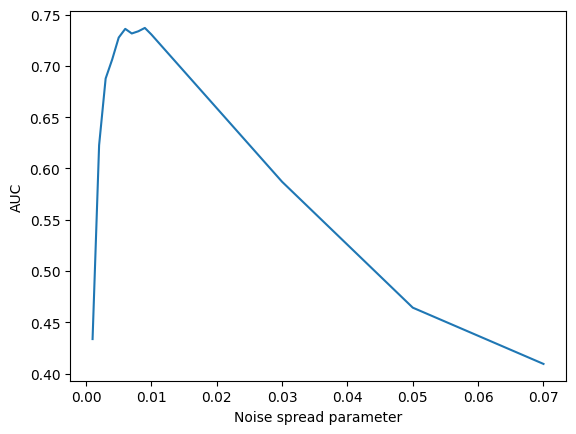

In [46]:
import matplotlib.pyplot as plt
plt.xlabel('Noise spread parameter')
plt.ylabel('AUC')
plt.plot(noise_, auc)

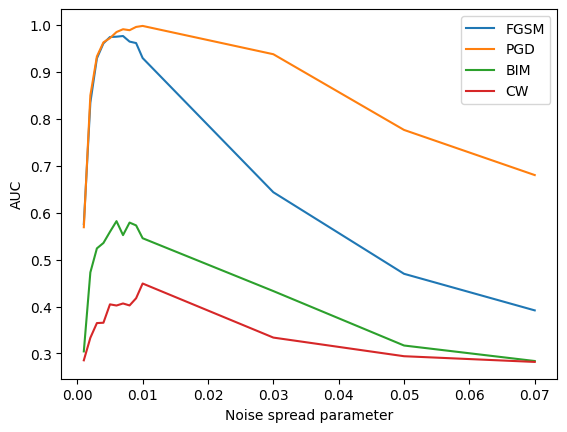

In [55]:

plt.plot(noise_, fgsm_auc_list, label="FGSM")
plt.plot(noise_, pgd_auc_list, label="PGD")
plt.plot(noise_, bim_auc_list, label="BIM")
plt.plot(noise_, cw_auc_list, label="CW")
plt.xlabel('Noise spread parameter')
plt.ylabel('AUC')

plt.legend()

plt.savefig('parameteranalysismnist.pdf', format='pdf', bbox_inches='tight')
plt.show()
